# KL-div on GS subspace
Perhaps KL needlessly obfuscates question: does FREM improve the probability of sampling the ground-state on near-term quantum annealers such as D-Wave's? Instead, maybe we should consider P_gs(annealing_method) as primary criterion and KL as one of theoretical interest? 
## Date: 11 January 2018

In [1]:
# The Stanard Hodgepodge of Imports for Python
import qutip as qt
import qutip.states as qts
import qutip.operators as qto
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import sys
import seaborn as sns
from functools import reduce
from functools import partial
from scipy.stats import entropy as entropy
import networkx as nx
import numpy as np
from timeit import default_timer as timer

sys.path.append("../dwaveutils/dwavetools")
sys.path.append("../dwaveutils/probrep")
from dictrep import DictRep
from dwavetools import (nqubit_1pauli, nqubit_2pauli, loadAandB, dict_to_qutip,
                       make_numeric_schedule, get_numeric_H, time_interpolation,
                       gs_calculator, random_partition, KL_div, ml_measurement)

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Set-up the Problem

[0.   0.   0.   0.   0.   0.   0.25 0.   0.   0.   0.25 0.   0.25 0.
 0.25 0.  ]


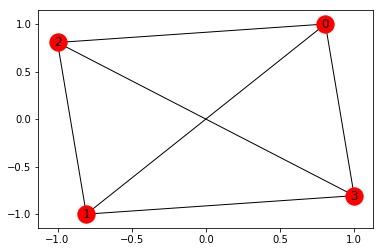

In [3]:
# First, let's create a sample 4 qubit Hamiltonian no h bias
dictH = {(0, 0): 1, (1, 1): 1, (2, 2): 1, (3, 3): -1, (0, 1): 1, (1, 2): 1, (2, 3): 1, (0, 3): 1, (1, 3): 1, (0, 2): 1}
H = DictRep(H = dictH, qpu = 'numerical', vartype = 'ising', encoding = 'logical')
graph = H.visualize_graph()
gs = H.diag_H()
print(gs)

In [12]:
# set-up the problem
T = 1
s = 0.5
ftr = 0.5
num_runs = 50

# time this as well
start = timer()
# run many instances of the problem with a random partition each time
for i in range(num_runs):
    results = H.frem_comparison(T, s, ftr)
end = timer()
elapsed_time = (end - start)
print("{} runs takes {} seconds to run".format(num_runs, elapsed_time))

data = H.data

50 runs takes 779.3751136120009 seconds to run


# Bulk Data Analysis

In [5]:
# get averages of KL divergence
fKL_avg = data.loc[data['method'] == 'forward']['KL_div'].mean()
print("Average KL divergence of forward annealing over {} runs is {}".format(num_runs, fKL_avg))
rKL_avg = data.loc[data['method'] == 'reverse']['KL_div'].mean()
print("Average KL divergence of reverse annealing over {} runs is {}".format(num_runs, rKL_avg))
fremKL_avg = data.loc[data['method'] == 'frem']['KL_div'].mean()
print("Average KL divergence of frem annealing over {} runs is {}".format(num_runs, fremKL_avg))

# get minimum values
fKL_min = data.loc[data['method'] == 'forward']['KL_div'].min()
print("Minimum KL divergence of forward annealing over {} runs is {}".format(num_runs, fKL_min))
rKL_min = data.loc[data['method'] == 'reverse']['KL_div'].min()
print("Minimum KL divergence of reverse annealing over {} runs is {}".format(num_runs, rKL_min))
fremKL_min = data.loc[data['method'] == 'frem']['KL_div'].min()
print("Minimum KL divergence of frem annealing over {} runs is {}".format(num_runs, fremKL_min))

Average KL divergence of forward annealing over 5 runs is 0.3712979777868924
Average KL divergence of reverse annealing over 5 runs is 1.6664206159413886
Average KL divergence of frem annealing over 5 runs is 0.6388467969270892
Minimum KL divergence of forward annealing over 5 runs is 0.3712979777868924
Minimum KL divergence of reverse annealing over 5 runs is 1.6664206159413886
Minimum KL divergence of frem annealing over 5 runs is 0.2735374051067671


# Finer Combed Data Analysis

## Are KL_divergence and ground-state probability equivalent 'experimental success criteria' (ESC)?

In [13]:
f_KL = data.loc[data['method'] == 'forward'].KL_div[0]
f_gsprob = data.loc[data['method'] == 'forward'].gs_prob[0]
frem_lower_KL = data.loc[data['method'] == 'frem'][data['KL_div'] < f_KL]
frem_lower_gsprob = data.loc[data['method'] == 'frem'][data['gs_prob'] > f_gsprob]
print("Number of frem trials with lower KL-div than forward: {}".format(len(frem_lower_KL)))
print("Number of frem trial with lower gsprob than forward: {}".format(len(frem_lower_gsprob)))

Number of frem trials with lower KL-div than forward: 16
Number of frem trial with lower gsprob than forward: 31


### This quick computation shows that there they are not equivalent. In fact, using ground-state probability as the appropriate criterion indicates shows that 31/50 trials are successful as compared to 16/50. 

## Do they at least follow the same "functional form" (i.e. related by a constant factor)?

In [14]:
data.loc[data['method'] == 'frem'][data['gs_prob'] > f_gsprob].sort_values('gs_prob', ascending=False)

,KL_div,T,ftr,gs_KL_div,gs_prob,method,part_size,probs,s
26,0.315726,1.0,0.5,0.265973,0.951465,frem,3.0,"[0.00021328471998986238, 0.0014934765445783333...",0.5
20,0.315726,1.0,0.5,0.265973,0.951465,frem,3.0,"[0.0002132847199898678, 0.0014934765445783536,...",0.5
2,0.501726,1.0,0.5,0.390938,0.895129,frem,3.0,"[0.00011438471920481049, 0.0003542260043182645...",0.5
164,0.501726,1.0,0.5,0.390938,0.895129,frem,3.0,"[0.00011438471920481079, 0.0003542260043182643...",0.5
146,0.214206,1.0,0.5,0.103191,0.894925,frem,2.0,"[0.0003114314980055508, 0.0011498468254938178,...",0.5
38,0.214206,1.0,0.5,0.103191,0.894925,frem,2.0,"[0.0003114314980055461, 0.0011498468254938117,...",0.5
62,0.214206,1.0,0.5,0.103191,0.894925,frem,2.0,"[0.0003114314980055461, 0.0011498468254938117,...",0.5
29,0.342192,1.0,0.5,0.230124,0.893984,frem,2.0,"[0.00033341424989312857, 0.018509560401513008,...",0.5
77,0.936239,1.0,0.5,0.823390,0.893286,frem,3.0,"[3.8509626069684166e-05, 0.0005163002550861999...",0.5
149,0.199073,1.0,0.5,0.081778,0.889323,frem,2.0,"[0.0004933660119077634, 0.000183414735128154, ...",0.5


### NO! There is not a clear relationship (monotone) between gs_prob and KL_div or gs_KL_div.

## Clearly, the "best" experimental outcome w.r.t. getting a ground-state is a highly asymmetric distrubtion. Let's take a look.

<BarContainer object of 4 artists>

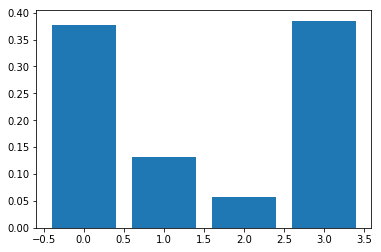

In [29]:
nonzero = np.nonzero(gs)[0]
plt.bar([i for i in range(len(nonzero))], data.iloc[26].probs[nonzero])
# NOTE, this is top solution

<BarContainer object of 4 artists>

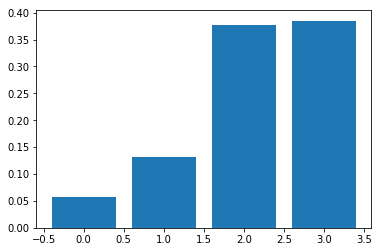

In [31]:
# 2nd best solution
plt.bar([i for i in range(len(nonzero))], data.iloc[20].probs[nonzero])

<BarContainer object of 4 artists>

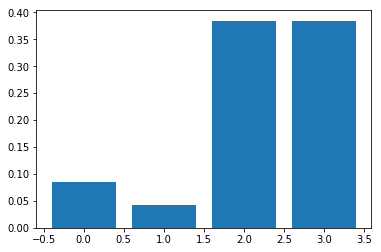

In [33]:
# 3rd best solution
plt.bar([i for i in range(len(nonzero))], data.iloc[2].probs[nonzero])

<BarContainer object of 4 artists>

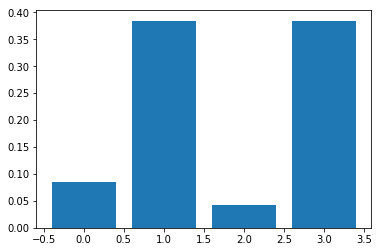

In [34]:
# 4th best solution
plt.bar([i for i in range(len(nonzero))], data.iloc[164].probs[nonzero])

<BarContainer object of 4 artists>

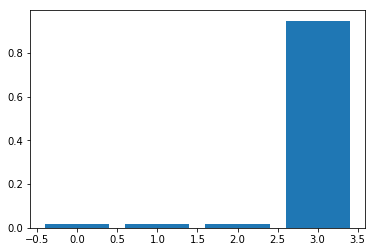

In [35]:
# random one that's better from above
plt.bar([i for i in range(len(nonzero))], data.iloc[28].probs[nonzero])

### Yes, the gs is highly asymmetric. Is it bias in the direction we would expect?

<BarContainer object of 4 artists>

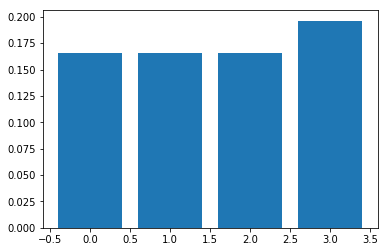

In [16]:
plt.bar([i for i in range(len(nonzero))], data.loc[data['method'] == 'forward'].probs[0][nonzero])

#### Evidently, Forward annealing has an asymmetry (why? Not sure in this case.) Though not shown, the states are:
* 1) |1001> 
* 2) |0101> 
* 3) |1100> 
* 4) |1110>
#### Hence, a "reverse" anneal as is done in FREM favors remnants of the |1110> state to start. However, which qubits are chosen is random, so a Hamming distance analysis (as I intially tried to do) is insufficient. One would need to understanding "seeding" effect of qubit chosen which is pretty involved.

# Conclusion

* gs_probability is a better measure of experimental near-term quantum annealer performance
* gs_probability and KL-div are not equivalent measures of performance
* FREM performs much better than previously thought w.r.t. gs_probability 
* However, it has a strong bias toward ground-states encoded through reverse anneal
* In other words, asymmetries in gs sampling from forward_annealing carry over to FREM
* For getting GS, this method is more effective, but may be worse (as is implemented) at finding them all (though this is debateable as well)